In [1]:
# Groupe H :
# Nom - numéro d'étudiant
# 
# NGUYEN Hoai Nam - 21512583 
# 
# NGUYEN Huu Khang - 21506865
# 
# NGUYEN Tran Tuan Nam - 21914400
#
# TRAN Thi Tra My - 21511002
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Load file
data = pd.read_csv('Dataset/claim_extraction_18_10_2019_annotated.csv', sep=',')

# Import outil sklearn

In [2]:
import time
import sklearn
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Sickit learn met régulièrement à jour des versions et indique des futurs warnings
# Ces deux lignes permettent de ne pas les afficher
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

#Import outil nltk pour traitement
import nltk
import unicodedata
import contractions
import inflect
#nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#pickle
import pickle


# Prétraitement

In [186]:
#initialize data3 
data3 = data.copy()

#Pré-traitement choisis : 
#On supprime les colonnes qui contiennent beaucoup des valeurs null
#Les valeurs qui augmente le temps d'exécution mais n'augmente pas une précision considérable
data3 = data3.drop('claimReview_author', 1)#manque beaucoup de valeur
data3 = data3.drop('claimReview_author_name', 1)# celui ci baisse la precision
data3 = data3.drop('creativeWork_author_sameAs', 1)#manque beaucoup de valeur
data3 = data3.drop('claimReview_author_url', 1)
data3 = data3.drop('claimReview_source', 1)#les données qui répetè beaucoup, celui ci baisse la précision
data3 = data3.drop('extra_entities_author', 1)#rend le classification très lourd
data3 = data3.drop('extra_entities_body', 1)#rend le classification très lourd
data3 = data3.drop('extra_entities_claimReview_claimReviewed', 1)#rend le classification très lourd
data3 = data3.drop('extra_entities_keywords', 1)#rend le classification très lourd
data3 = data3.drop('extra_refered_links',1) #ne servent pas pour l'analyse et baisse la précision

######Stop words
#initialize stop words type
stop_words = stopwords.words('english')

#pos-tagging
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

######Pre traiter le données du texte
def pretraiter(text):  
    if(isinstance(text, str) and text ) :
        #Remove contractions
        text = contractions.fix(text)

        #remove URL
        text = re.sub(r"http\S+", "", text)
        
        #remove photo url
        text = re.sub(r"pic.\S+", "", text)

        # Tokenizing
        tokenizedText = word_tokenize(text)
        
        #Remove non-ASCII characters from list of tokenized words
        new_words = []
        for word in tokenizedText:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        tokenizeText = new_words

        # Put all words in lowercase
        tokenizedText = [word.lower() for word in tokenizedText]

        # Delete ponctuations
        tokenizedText = [word for word in tokenizedText if word.isalpha()]

        #remove stop_word
        tokenizedText = [word for word in tokenizedText if not word in stop_words]
        
        # Converting numbers
        p = inflect.engine()
        newWords = []
        for word in tokenizedText:
            if word.isdigit():
                newWords.append(p.number_to_words(word))
            else:
                newWords.append(word)
        tokenizedText = newWords

        # Lemmatization + pos-tagging
        lemmatizer = WordNetLemmatizer()
        #tokenizedText = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokenizedText]
        tokenizedText = [lemmatizer.lemmatize(word, 'v') for word in tokenizedText]
        # Turning back tokens into a string
        text = "".join([" " + i for i in tokenizedText]).strip()
        return text
    
    
##### Prétraiter alternateName
def pretraiter_alternatename (text) :
    if(isinstance(text, str) and text ) :
        # Tokenizing
        tokenizedText = word_tokenize(text)
        
        # Put all words in lowercase
        tokenizedText = [word.lower() for word in tokenizedText]
        
        if tokenizedText[0] == 'true':
            return 1
        else :
            return 0
        
    else :
        return 0
    
def pretraiter_alternatename_bis (text) :
    if(isinstance(text, str) and text ) :
        # Tokenizing
        tokenizedText = word_tokenize(text)
        
        # Put all words in lowercase
        tokenizedText = [word.lower() for word in tokenizedText]
        
        if tokenizedText[0] == 'true' or tokenizedText[1] == 'false':
            return 1
        else :
            return 0
        
    else :
        return 0
    

In [187]:
#Exécution pretraitement
data3['extra_body'] = data['extra_body'].apply(lambda x: pretraiter(x))
data3['claimReview_claimReviewed'] = data['claimReview_claimReviewed'].apply(lambda x: pretraiter(x))
data3['rating_alternateName'] = data['rating_alternateName'].apply(lambda x: pretraiter_alternatename(x))

In [188]:
#Prétraitement avec les fonctions existants
data3 = data3[data3['extra_body'].notna()]
data3['claimReview_claimReviewed'] = data3['claimReview_claimReviewed'].fillna('Inconnu')
data3['creativeWork_author_name'] = data3['creativeWork_author_name'].fillna('Inconnu')
data3['extra_tags'] = data3['extra_tags'].fillna('Inconnu')
data3['claimReview_datePublished'] = data3['claimReview_datePublished'].fillna('Inconnu')
data3['creativeWork_datePublished'] = data3['creativeWork_datePublished'].fillna('Inconnu')
moyen_bestRating = data['rating_bestRating'].mean()
moyen_ratingValue = data['rating_ratingValue'].mean()
moyen_worstRating = data['rating_worstRating'].mean()
data3['rating_bestRating'] = data3['rating_bestRating'].fillna(moyen_bestRating)
data3['rating_ratingValue'] = data3['rating_ratingValue'].fillna(moyen_ratingValue)
data3['rating_worstRating'] = data3['rating_worstRating'].fillna(moyen_worstRating)

In [190]:
# Utilisation de Downsampling car nous avons beaucoup de valeur false
data3_majority = data3[data3.rating_alternateName==0]
data3_minority = data3[data3.rating_alternateName==1]
data3_majority_downsampled = resample(data3_majority, replace = False, n_samples = 4594, random_state = 123)
data3_downsampled = pd.concat([data3_majority_downsampled, data3_minority])


In [205]:
le = preprocessing.LabelEncoder() #transformer les valeurs str en valeurs numérique
#le_data = data3.apply(le.fit_transform)
le_data = data3_downsampled.apply(le.fit_transform)#utilisation downsampling pour les données équilibrées
array = le_data.values
X = array[:,1:13]
y = array[:,9]


validation_size=0.3 #30% du jeu de données pour le test
testsize= 1-validation_size
seed=30
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=validation_size,random_state=seed,test_size=testsize)

# Utilisation de kFold pour le classifieurs avec les données par défauts

In [206]:
seed = 10 
scoring = 'accuracy'
models = []
models.append(('RFC', RandomForestClassifier()))
models.append(('LR', LogisticRegression(max_iter=4000)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=4)))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC(gamma='auto'))) #Le temps d'exécution était très important

results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, shuffle = True, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 

Time pour RFC   2.661090612411499
RFC: 1.000000 (0.000000)
Time pour LR   1.4712328910827637
LR: 1.000000 (0.000000)
Time pour KNN   0.15308809280395508
KNN: 0.572196 (0.015593)
Time pour DTC   0.03128218650817871
DTC: 1.000000 (0.000000)
Time pour NB   0.026218891143798828
NB: 1.000000 (0.000000)


[Text(0, 0, 'RFC'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'DTC'),
 Text(0, 0, 'NB')]

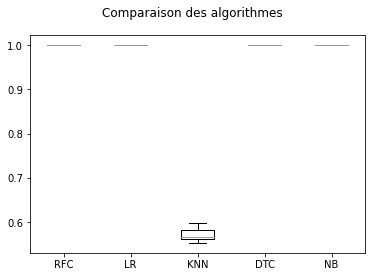

In [207]:
#Visualiser le résultat
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

In [208]:
#classification DecisionTreeClassifier
clf=DecisionTreeClassifier(random_state=40)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print('\DTC accuracy :', accuracy_score(result, y_test),'\n')


conf = confusion_matrix(y_test, result)
print ('\n matrice de confusion \n',conf)
print ('\n',classification_report(y_test, result))

#classification RandomForestClassifier
clf=RandomForestClassifier()
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print('\RFC accuracy :', accuracy_score(result, y_test),'\n')

conf = confusion_matrix(y_test, result)
print ('\n matrice de confusion \n',conf)
print ('\n',classification_report(y_test, result))

\DTC accuracy : 1.0 


 matrice de confusion 
 [[3226    0]
 [   0 3206]]

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3226
           1       1.00      1.00      1.00      3206

    accuracy                           1.00      6432
   macro avg       1.00      1.00      1.00      6432
weighted avg       1.00      1.00      1.00      6432

\RFC accuracy : 1.0 


 matrice de confusion 
 [[3226    0]
 [   0 3206]]

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3226
           1       1.00      1.00      1.00      3206

    accuracy                           1.00      6432
   macro avg       1.00      1.00      1.00      6432
weighted avg       1.00      1.00      1.00      6432



# Utilisation de Gris search pour multiples classifieurs et ses parametres

In [209]:
#Initialiser les données
classifiers = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'LogisticRegression' : LogisticRegression(solver='lbfgs'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
}

parameters = {
    'RandomForestClassifier' :[
        {'n_estimators': [4, 6, 9]},
        {'max_features': ['log2', 'sqrt','auto']},
        {'criterion': ['entropy', 'gini']},
        {'max_depth': [2, 3, 5, 10]},
        {'min_samples_split': [2, 3, 5]},
        {'min_samples_leaf': [1,5,8]}],
    
    'LogisticRegression': [
        {'max_iter': [4000]},
        {'penalty': ['l2']}, 
        {'C': [0.001,0.01,0.1,1,10,100,1000]}
    ],
    'KNeighborsClassifier' : [
        {'n_neighbors': list(range(1,15))}, 
        {'metric': ['minkowski','euclidean','manhattan']}
    ],
    'DecisionTreeClassifier' : [
        {'max_depth': [1,2,3,4,5,6,7,8,9,10]}, 
        {'criterion': ['gini', 'entropy']}, 
        {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}
    ],
}

    
class Result:
    def __init__(self,name, score, parameters):
        self.name = name
        self.parameters = parameters
        self.score = score

    def __repr__(self):
        return repr((self.name, self.score, self.parameters))
    
results = []
for key, value in classifiers.items():
    gd_sr = GridSearchCV(estimator = value, 
                         param_grid = parameters[key], 
                         scoring = "accuracy", 
                         cv = 5,
                         n_jobs = -1,#utilisation de plusieurs coeur pour l'exécution
                         iid = True)
    
    #gd_sr.fit(X, y)#données initiales
    gd_sr.fit(X_train, y_train)
    
    result = Result(key, 
                    gd_sr.best_score_,
                    gd_sr.best_estimator_)
    results.append(result)

In [210]:
results = sorted(results, key = lambda result: result.score, reverse = True)

print("Results from best to worst: \n")
for result in results:
    print ("Classifier: ", result.name,
    " with score %0.2f " %result.score, 
    "avec ", result.parameters,'\n')


Results from best to worst: 

Classifier:  RandomForestClassifier  with score 1.00  avec  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=6,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Classifier:  LogisticRegression  with score 1.00  avec  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                 

# Utilisation d'une pipeline et GridSearchCV pour sauvegarder le meilleur modèle

In [236]:
print ('Création du pipeline \n')
clf = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classification', RandomForestClassifier())
])

clf.fit(X_train, y_train)
result = clf.predict(X_test)

print('\n accuracy:',accuracy_score(result, y_test),'\n')

matrix = confusion_matrix(y_test, result)
print ('\nMatrice de confusion: \n', matrix, "\n")

print ('\n', classification_report(y_test, result), "\n")

Création du pipeline 


 accuracy: 0.7518656716417911 


Matrice de confusion: 
 [[2447  779]
 [ 817 2389]] 


               precision    recall  f1-score   support

           0       0.75      0.76      0.75      3226
           1       0.75      0.75      0.75      3206

    accuracy                           0.75      6432
   macro avg       0.75      0.75      0.75      6432
weighted avg       0.75      0.75      0.75      6432
 



In [216]:
#Sauvegarder le modèle choisi

clf=RandomForestClassifier()
clf.fit(X_train, y_train)

filename = 'pkl_modelDTC.sav'
pickle.dump(clf, open(filename, 'wb'))

clf_loaded = pickle.load(open(filename, 'rb'))
print ('Modèle chargé',clf_loaded,'\n')
result = clf_loaded.predict(X_test)

print('\n accuracy:\n')
print (accuracy_score(result, y_test),'\n')

conf = confusion_matrix(y_test, result)
print ('\n matrice de confusion \n',conf)
print ('\n',classification_report(y_test, result))


Modèle chargé RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 


 accuracy:

1.0 


 matrice de confusion 
 [[3226    0]
 [   0 3206]]

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3226
           1       1.00      1.00      1.00      3206

    accuracy                           1.00      6432
   macro avg       1.00      1.00      1.00      6432
weighted avg       1.00      1.00      1.00      6432



In [ ]:
#Sauvegarder une csv
data3.to_csv('clean_data_fact-checking.csv', sep=';', index=False)